Plots: K2 Objects with moving small aperture + (SFF or PLD)

In [42]:
from agn_everest.analysis import *

import richardsplot

In [22]:
def frame_backmask(tpf, frame=0, bk_threshold=0.05, use_prf=True):
    """
    Calculate the aperture mask for a given frame
    """
    
    if use_prf:

        # get pixel coords (corrections)
        ra,dec = tpf.ra,tpf.dec
        dcol, drow = tpf.wcs.wcs_world2pix(ra,dec,0)
        col = dcol + tpf.column + tpf.pos_corr1 # correct col coord (depends on time)
        row = drow + tpf.row + tpf.pos_corr2 # correct row coord (depends on time)

        # calculte background mask
        prf = tpf.get_prf_model()

        thresh = np.nanpercentile(prf.evaluate(col[frame],row[frame],flux=1), bk_threshold*100)
        backmask = (prf.evaluate(col[frame],row[frame],flux=1) < thresh)
        
    else:
        thresh = np.nanpercentile(tpf.flux[frame], bk_threshold*100)
        backmask = (tpf.flux[frame] < thresh)
    

    return backmask


def apply_moving_aperture(tpf, remove_spurious=True, **kwargs):
    """
    Subtracts median background with moving aperture mask
        - args
        bk_threshold: percentile below which a pixel counts as a background pixel
            (default is 0.05th percentile)
        frame: which frame to use for calculation

    - returns
        lc: background subtracted light curve
        ap[0]: first frame of the moving aperture mask
    """
    #lc = tpf.to_lightcurve(aperture_mask='all')
    #_, spurious_cadences = lc.flatten().remove_outliers(return_mask=True)

    backmask_list = []
    aperturemask_list = []
    # calculate flux of moving aperture mask
    for frame, flux in enumerate(tpf.flux):

        backmask = frame_backmask(tpf, frame, **kwargs)
        backmask_list.append(backmask)

        postage_stamp_mask = tpf.hdu[2].data > 0
        apmask = ~backmask & postage_stamp_mask
        aperturemask_list.append(apmask)

    # convert the calculated masks into 3D arrays
    bk = np.array(backmask_list)
    ap = np.array(aperturemask_list)

    # take a copy of the flux and apply the masks to it
    # (the false values are replaced with NaNs to avoid flattening the array)
    background = tpf.flux.copy()
    background[~bk] = np.nan
    aperture = tpf.flux.copy()
    aperture[~ap] = np.nan

    # the light curves can be calculated by summing the flux of pixels each time step
    lc_apermask = np.nansum(aperture, axis=2).sum(axis=1)

    """
    # calculate number pixels in target and num in background
    N_targ_pixels, N_back_pixels = ap.sum(axis=2).sum(axis=1), bk.sum(axis=2).sum(axis=1)

    # need to reshape to do median background properly
    # flat_pixels is array where first dimension is frame,second dimension is the flattened array of pixel values
    flat_pixels = background.reshape((background.shape[0], background.shape[1]*background.shape[2]))
    lc_back_per_pix_med = np.nanmedian(flat_pixels, axis=1)

    # Smoothing the background (basically a weighted moving avarage)
    kernel = Gaussian1DKernel(50)
    lc_back_per_pix_med = convolve(lc_back_per_pix_med, kernel, boundary='extend')

    
    # subtract background
    lc_net = lc_apermask - lc_back_per_pix_med* N_targ_pixels
    if remove_spurious:
        lc_net = lc_net[~spurious_cadences] # remove spurious cadences

    # keep the kepler lightcuve object form, just overwrite flux value
    # flux_err is probably incorrect now
    if remove_spurious:
        lc_clean = lc[~spurious_cadences]
    else:
        lc_clean = lc
    lc_clean.flux = lc_net

    return lc_clean, ap[0]
    """
    
    return tpf.time, lc_apermask


In [34]:
# objects for testing ("bad" objects)
test_objects = [220176344,251391156,220465821,211707981]
test_campaigns = [8, 16, 8,  16]
test_mags = [12.966, 14.420, 15.744,13.096]

/home/rachel/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
/home/rachel/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
/home/rachel/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/rachel/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:613: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/rachel/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


CPU times: user 27.2 s, sys: 235 ms, total: 27.4 s
Wall time: 28.2 s


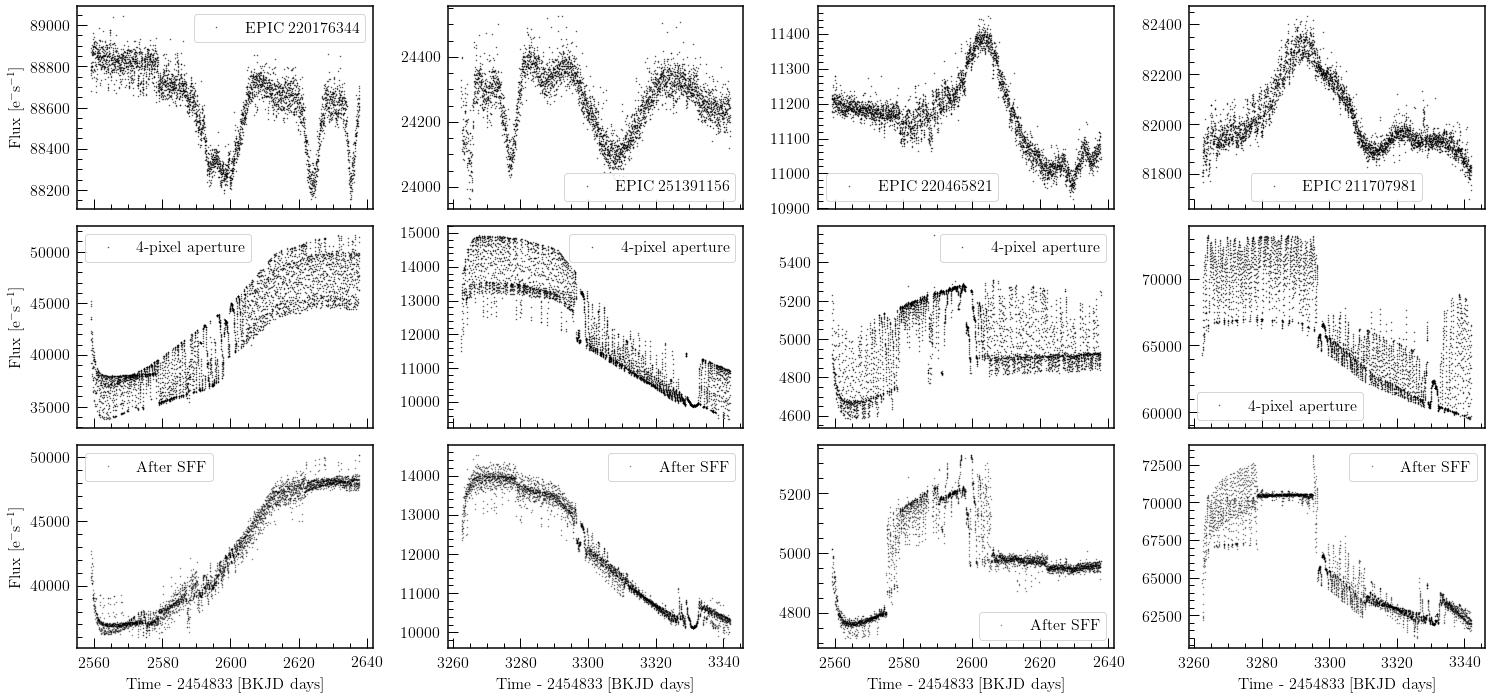

In [59]:
%%time 
npix=4 # number of pixels in the aperture
fig, ax = plt.subplots(3, len(test_objects), figsize=(21,10), sharex='col')


for ind, epic in enumerate(test_objects):
    campaign = test_campaigns[ind]
    mag = test_mags[ind]
    # do the work
    tpf = lk.search_targetpixelfile(epic, mission='K2', campaign=campaign).download()

    total_pix = tpf.shape[1]*tpf.shape[2]
    time, flux = apply_moving_aperture(tpf, bk_threshold=(total_pix-npix)/total_pix, use_prf=False)

    # apply SFF corrector
    lc = lk.LightCurve(time=time, flux=flux, label="EPIC %s"%epic)
    corrector = lk.SFFCorrector(lc)
    cor_lc = corrector.correct(tpf.pos_corr2, tpf.pos_corr1, niters=4, windows=5, bins=7, restore_trend=True)

    
    # remove spurious cadencess and Plot
    lc_raw = tpf.to_lightcurve(aperture_mask="all")
    _, spurious_cadences = lc_raw.flatten().remove_outliers(return_mask=True)
    lc_raw = lc_raw[~spurious_cadences]
    lc_raw.plot(ax = ax[0, ind], normalize=False, marker='.', ls='',alpha=0.7, color='k')
    ax[0, ind].set_xlabel("")

    _, spurious_cadences = lc.flatten().remove_outliers(return_mask=True)
    lc = lc[~spurious_cadences]
    lc.plot(ax=ax[1, ind], normalize=False, marker='.', ls='', alpha=0.7, color='k',label = "%s-pixel aperture"%npix)
    ax[1, ind].set_xlabel("")
    
    _, spurious_cadences = cor_lc.flatten().remove_outliers(return_mask=True)
    lc_clean_sff = cor_lc[~spurious_cadences]
    lc_clean_sff.plot(ax=ax[2, ind], normalize=False, marker='.', ls='', alpha=0.5, color='k', label="After SFF")
    ax[2, ind].set_xlabel("Time - 2454833 [BKJD days]")
    ax[2, ind].xaxis.label.set_fontsize(16)

    ax[0, ind].legend(fontsize=16)
    ax[1, ind].legend(fontsize=16)
    ax[2, ind].legend(fontsize=16)
    if ind>0:
        ax[0, ind].set_ylabel("")
        ax[1, ind].set_ylabel("")
        ax[2, ind].set_ylabel("")
    else:
        ax[0, ind].xaxis.label.set_fontsize(16)
        ax[1, ind].xaxis.label.set_fontsize(16)
        ax[2, ind].xaxis.label.set_fontsize(16)
plt.tight_layout()
plt.savefig("submit/Plots/movingAperture_%s-pix.pdf"%npix)

/home/rachel/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
/home/rachel/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
/home/rachel/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
/home/rachel/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less


CPU times: user 25 s, sys: 272 ms, total: 25.2 s
Wall time: 26.1 s


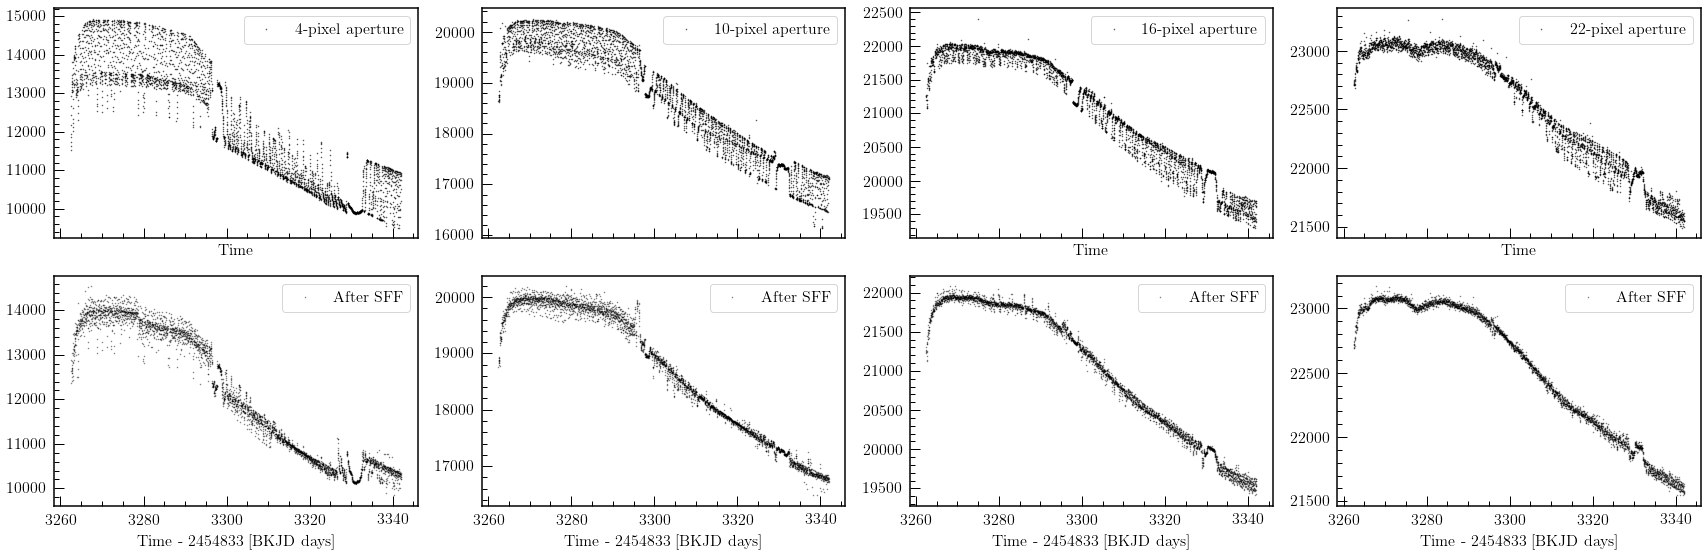

In [66]:
%%time 

pixels = np.arange(4, 24, 6)
fig, ax = plt.subplots(2, len(pixels), figsize=(24,8), sharex='col')

ind=1
epic = test_objects[ind]
campaign = test_campaigns[ind]
mag = test_mags[ind]

# do the work
tpf = lk.search_targetpixelfile(epic, mission='K2', campaign=campaign).download()
total_pix = tpf.shape[1]*tpf.shape[2]

for i, npix in enumerate(pixels):

    time, flux = apply_moving_aperture(tpf, bk_threshold=(total_pix-npix)/total_pix, use_prf=False)

    # apply SFF corrector
    lc = lk.LightCurve(time=time, flux=flux, label="EPIC %s"%epic)
    corrector = lk.SFFCorrector(lc)
    cor_lc = corrector.correct(tpf.pos_corr2, tpf.pos_corr1, niters=4, windows=5, bins=7, restore_trend=True)
    
    # remove spurious cadencess and Plot
    '''
    lc_raw = tpf.to_lightcurve(aperture_mask="all")
    _, spurious_cadences = lc_raw.flatten().remove_outliers(return_mask=True)
    lc_raw = lc_raw[~spurious_cadences]
    lc_raw.plot(ax = ax[0, i], normalize=False, marker='.', ls='',alpha=0.7, color='k')
    ax[0, i].set_xlabel("")
    '''
    _, spurious_cadences = lc.flatten().remove_outliers(return_mask=True)
    lc = lc[~spurious_cadences]
    lc.plot(ax=ax[0, i], normalize=False, marker='.', ls='', alpha=0.7, color='k',label = "%s-pixel aperture"%npix)
    ax[0, ind].set_xlabel("")
    
    _, spurious_cadences = cor_lc.flatten().remove_outliers(return_mask=True)
    lc_clean_sff = cor_lc[~spurious_cadences]
    lc_clean_sff.plot(ax=ax[1, i], normalize=False, marker='.', ls='', alpha=0.5, color='k', label="After SFF")
    ax[1, i].set_xlabel("Time - 2454833 [BKJD days]")
    ax[1, i].xaxis.label.set_fontsize(16)

    ax[0, i].legend(fontsize=16)
    ax[1, i].legend(fontsize=16)
    if ind>0:
        ax[0, i].set_ylabel("")
        ax[1, i].set_ylabel("")
    else:
        ax[0, i].xaxis.label.set_fontsize(16)
        ax[1, i].xaxis.label.set_fontsize(16)
plt.tight_layout()
#plt.savefig("submit/Plots/EPIC_%s_movingAperture_n-pix-test.pdf"%(epic, snpix))